In [2]:
import torch
from ray import tune
import ray
import numpy as np
import os
from pytorch_optimizer import AvaGrad 
from train import train
import pickle
from ray.train.lightning import LightningTrainer
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter



## Loading and Cleaning Metrics

In [3]:
result_grid = tune.Tuner.restore("tune_cifar10_SmallNet_no_ckpt/tune_cifar10_SmallNet", trainable=LightningTrainer).get_results()
metrics_df = result_grid.get_dataframe()
#metrics_df = pd.concat([pd.concat([result, result.metrics_dataframe], axis=1) for result in analysis], ignore_index=True)
display(metrics_df)

Failed to read the results for 1 trials:
- tune_cifar10_SmallNet_no_ckpt/tune_cifar10_SmallNet/LightningTrainer_8843f_00746_746_SAM=True,optimizer=ref_ph_6e59c6b3,lr=0.0027,weight_decay=0.0000_2023-07-02_13-56-47
The requested checkpoint is not available on this node, most likely because you are using Ray client or disabled checkpoint synchronization. To avoid this, enable checkpoint synchronization to cloud storage by specifying a `SyncConfig`. The checkpoint may be available on a different  node - please check this location on worker nodes: tune_cifar10_SmallNet_no_ckpt/tune_cifar10_SmallNet/LightningTrainer_8843f_00000_0_SAM=True,optimizer=ref_ph_e503d28a,lr=1.0000,weight_decay=0.1000_2023-07-01_21-07-32/checkpoint_000019


,_report_on,val_loss,train_loss,epoch,step,timestamp,time_this_iter_s,should_checkpoint,done,training_iteration,...,config/lightning_config/_trainer_init_config/callbacks,config/lightning_config/_trainer_init_config/limit_train_batches,config/lightning_config/_trainer_init_config/limit_val_batches,config/lightning_config/_trainer_init_config/logger,config/lightning_config/_trainer_init_config/max_epochs,config/lightning_config/_module_init_config/config/SAM,config/lightning_config/_module_init_config/config/optimizer,config/lightning_config/_module_init_config/config/parameters/lr,config/lightning_config/_module_init_config/config/parameters/weight_decay,logdir
0,train_epoch_end,2.307307,2.303948,19,7820,1688238531,3.704602,True,False,20,...,[<pytorch_lightning.callbacks.progress.rich_pr...,0.5,1,None,20,True,<class 'torch.optim.sgd.SGD'>,1.000000,1.000000e-01,tune_cifar10_SmallNet_no_ckpt/tune_cifar10_Sma...
1,train_epoch_end,2.307106,2.303834,19,7820,1688238607,3.282485,True,False,20,...,[<pytorch_lightning.callbacks.progress.rich_pr...,0.5,1,None,20,False,<class 'torch.optim.sgd.SGD'>,1.000000,1.000000e-01,tune_cifar10_SmallNet_no_ckpt/tune_cifar10_Sma...
2,train_epoch_end,2.304007,2.302599,19,7820,1688238691,3.658920,True,False,20,...,[<pytorch_lightning.callbacks.progress.rich_pr...,0.5,1,None,20,True,<class 'pytorch_optimizer.optimizer.avagrad.Av...,1.000000,1.000000e-01,tune_cifar10_SmallNet_no_ckpt/tune_cifar10_Sma...
3,train_epoch_end,2.028016,2.096122,19,7820,1688238770,3.426250,True,False,20,...,[<pytorch_lightning.callbacks.progress.rich_pr...,0.5,1,None,20,False,<class 'pytorch_optimizer.optimizer.avagrad.Av...,1.000000,1.000000e-01,tune_cifar10_SmallNet_no_ckpt/tune_cifar10_Sma...
4,train_epoch_end,2.305197,2.302746,19,7820,1688238850,3.475510,True,False,20,...,[<pytorch_lightning.callbacks.progress.rich_pr...,0.5,1,None,20,True,<class 'torch.optim.sgd.SGD'>,0.372759,1.000000e-01,tune_cifar10_SmallNet_no_ckpt/tune_cifar10_Sma...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741,train_epoch_end,1.258943,1.085192,19,7820,1688298632,4.039773,True,False,20,...,[<pytorch_lightning.callbacks.progress.rich_pr...,0.5,1,None,20,False,<class 'torch.optim.sgd.SGD'>,0.007197,1.389495e-08,tune_cifar10_SmallNet_no_ckpt/tune_cifar10_Sma...
742,train_epoch_end,1.411554,1.403883,19,7820,1688298739,5.214130,True,False,20,...,[<pytorch_lightning.callbacks.progress.rich_pr...,0.5,1,None,20,True,<class 'pytorch_optimizer.optimizer.avagrad.Av...,0.007197,1.389495e-08,tune_cifar10_SmallNet_no_ckpt/tune_cifar10_Sma...
743,train_epoch_end,1.153348,1.108285,19,7820,1688298837,4.856669,True,False,20,...,[<pytorch_lightning.callbacks.progress.rich_pr...,0.5,1,None,20,False,<class 'pytorch_optimizer.optimizer.avagrad.Av...,0.007197,1.389495e-08,tune_cifar10_SmallNet_no_ckpt/tune_cifar10_Sma...
744,train_epoch_end,2.300405,2.302069,19,7820,1688298924,3.908327,True,False,20,...,[<pytorch_lightning.callbacks.progress.rich_pr...,0.5,1,None,20,True,<class 'torch.optim.sgd.SGD'>,0.002683,1.389495e-08,tune_cifar10_SmallNet_no_ckpt/tune_cifar10_Sma...


In [4]:
metrics_df_cleaned= metrics_df.rename(columns={"config/lightning_config/_module_init_config/config/SAM":"SAM", "config/lightning_config/_module_init_config/config/optimizer":"optimizer", "config/lightning_config/_module_init_config/config/parameters/lr":"lr","config/lightning_config/_module_init_config/config/parameters/weight_decay":"weight_decay" })
metrics_df_cleaned = metrics_df_cleaned[["val_loss", "train_loss", "epoch", "lr", "weight_decay", "optimizer", "SAM"]]
diff_loss = pd.DataFrame(metrics_df_cleaned["val_loss"].subtract(metrics_df_cleaned["train_loss"]), columns=["diff_loss"])
metrics_df_cleaned = pd.concat([metrics_df_cleaned, diff_loss], axis=1)
display(metrics_df_cleaned.head())

,val_loss,train_loss,epoch,lr,weight_decay,optimizer,SAM,diff_loss
0,2.307307,2.303948,19,1.000000,0.1,<class 'torch.optim.sgd.SGD'>,True,0.003359
1,2.307106,2.303834,19,1.000000,0.1,<class 'torch.optim.sgd.SGD'>,False,0.003272
2,2.304007,2.302599,19,1.000000,0.1,<class 'pytorch_optimizer.optimizer.avagrad.Av...,True,0.001408
3,2.028016,2.096122,19,1.000000,0.1,<class 'pytorch_optimizer.optimizer.avagrad.Av...,False,-0.068106
4,2.305197,2.302746,19,0.372759,0.1,<class 'torch.optim.sgd.SGD'>,True,0.002451


## Convergence

In [5]:
def plot_all(result_grid):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    for result in result_grid:
        parameters = result.config["lightning_config"]["_module_init_config"]["config"]["parameters"]
        label = f"lr={parameters['lr']}, momentum={parameters['weight_decay']}"
        result.metrics_dataframe.plot("epoch", "train_loss", ax=ax[0], legend=False)
        result.metrics_dataframe.plot("epoch", "val_loss", ax=ax[1], legend=False)
    ax[0].set_title("Train Loss vs. Epoch for All Trials")
    ax[1].set_title("Validation Loss vs. Epoch for All Trials")
    ax[0].set_ylabel("Mean Train Loss")
    ax[1].set_ylabel("Mean Validation Loss")
#plot_all(result_grid)

## Function for creating Heatmaps

In [6]:
def plot_heatmap_2d(ax, df, title="Default Title", vmin=0, vmax=2.5):
    sns.heatmap(df, ax=ax, vmin=vmin, vmax=vmax)

    # Format x-tick labels
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels = [f'{float(label):.1e}' for label in labels]
    ax.set_xticklabels(labels)

    # Format y-tick labels
    labels = [item.get_text() for item in ax.get_yticklabels()]
    labels = [f'{float(label):.1e}' for label in labels]
    ax.set_yticklabels(labels)
    ax.set_title(title)
    plt.tight_layout()

# Results

## Without SAM

### Train loss

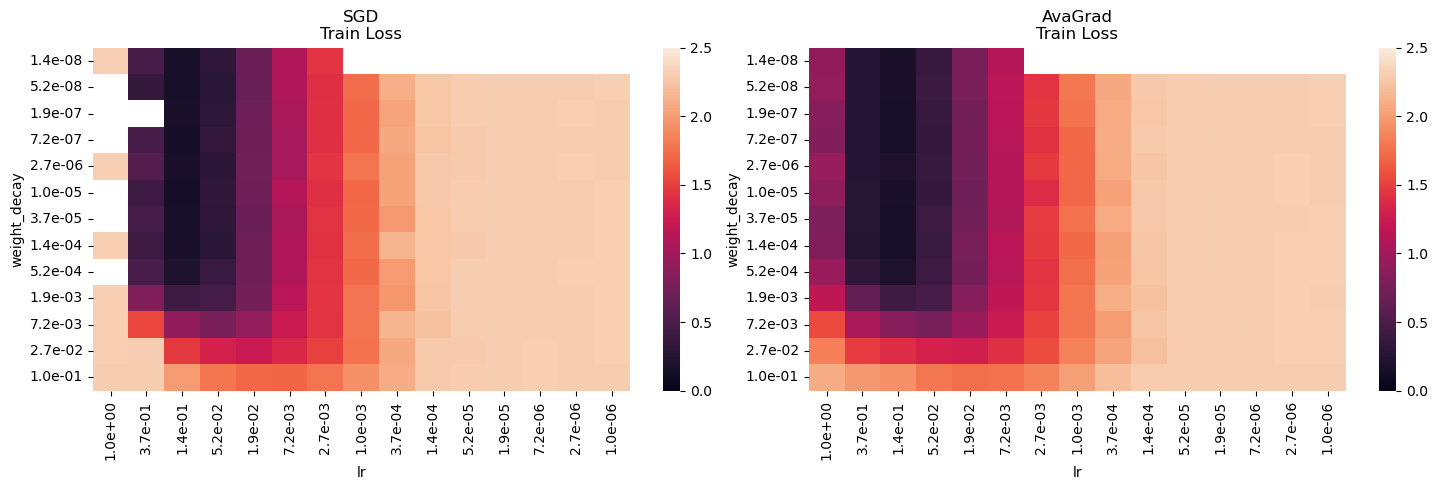

In [7]:
train_loss_sgd = metrics_df_cleaned[(metrics_df_cleaned["SAM"]==False) & (metrics_df_cleaned["optimizer"]=="<class 'torch.optim.sgd.SGD'>")].pivot(index="weight_decay", columns="lr", values="train_loss")
train_loss_sgd.sort_index(axis=1, inplace=True, ascending=False)
train_loss_avagrad = metrics_df_cleaned[(metrics_df_cleaned["SAM"]==False) & (metrics_df_cleaned["optimizer"]=="<class 'pytorch_optimizer.optimizer.avagrad.AvaGrad'>")].pivot(index="weight_decay", columns="lr", values="train_loss")
train_loss_avagrad.sort_index(axis=1, inplace=True, ascending=False)


fig, axs = plt.subplots(1, 2, figsize=(15, 5))

plot_heatmap_2d(axs[0], train_loss_sgd, "SGD\n(Train Loss)")
plot_heatmap_2d(axs[1], train_loss_avagrad, "AvaGrad\n(Train Loss)")
plt.show()

### Test loss

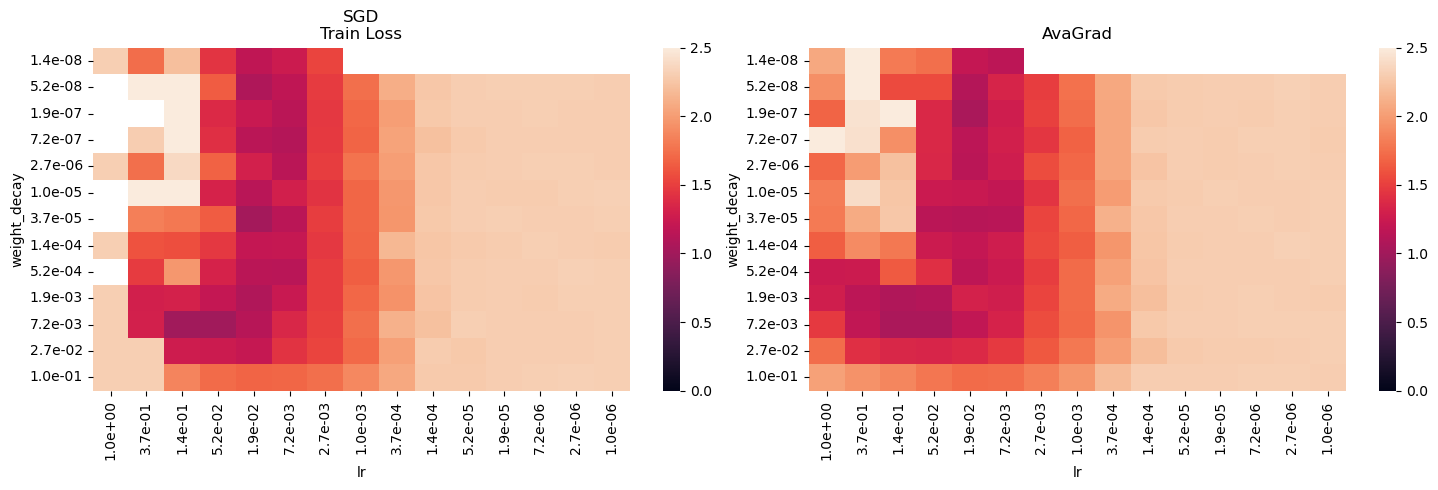

In [8]:
test_loss_sgd = metrics_df_cleaned[(metrics_df_cleaned["SAM"]==False) & (metrics_df_cleaned["optimizer"]=="<class 'torch.optim.sgd.SGD'>")].pivot(index="weight_decay", columns="lr", values="val_loss")
test_loss_sgd.sort_index(axis=1, inplace=True, ascending=False)
test_loss_avagrad = metrics_df_cleaned[(metrics_df_cleaned["SAM"]==False) & (metrics_df_cleaned["optimizer"]=="<class 'pytorch_optimizer.optimizer.avagrad.AvaGrad'>")].pivot(index="weight_decay", columns="lr", values="val_loss")
test_loss_avagrad.sort_index(axis=1, inplace=True, ascending=False)


fig, axs = plt.subplots(1, 2, figsize=(15, 5))

plot_heatmap_2d(axs[0], test_loss_sgd, "SGD\n(Test Loss)")
plot_heatmap_2d(axs[1], test_loss_avagrad, "AvaGrad")
plt.show()

### Diff loss

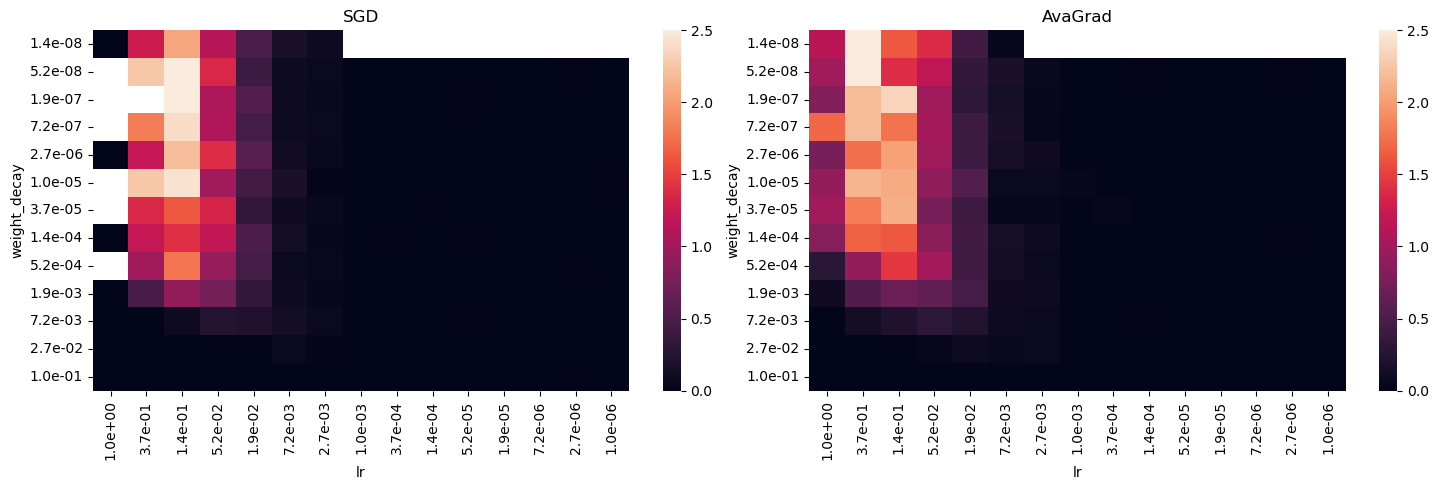

In [9]:
diff_loss_sgd = metrics_df_cleaned[(metrics_df_cleaned["SAM"]==False) & (metrics_df_cleaned["optimizer"]=="<class 'torch.optim.sgd.SGD'>")].pivot(index="weight_decay", columns="lr", values="diff_loss")
diff_loss_sgd.sort_index(axis=1, inplace=True, ascending=False)
diff_loss_avagrad = metrics_df_cleaned[(metrics_df_cleaned["SAM"]==False) & (metrics_df_cleaned["optimizer"]=="<class 'pytorch_optimizer.optimizer.avagrad.AvaGrad'>")].pivot(index="weight_decay", columns="lr", values="diff_loss")
diff_loss_avagrad.sort_index(axis=1, inplace=True, ascending=False)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

plot_heatmap_2d(axs[0], diff_loss_sgd, "SGD")
plot_heatmap_2d(axs[1], diff_loss_avagrad, "AvaGrad")
plt.show()

## With SAM

### Train loss

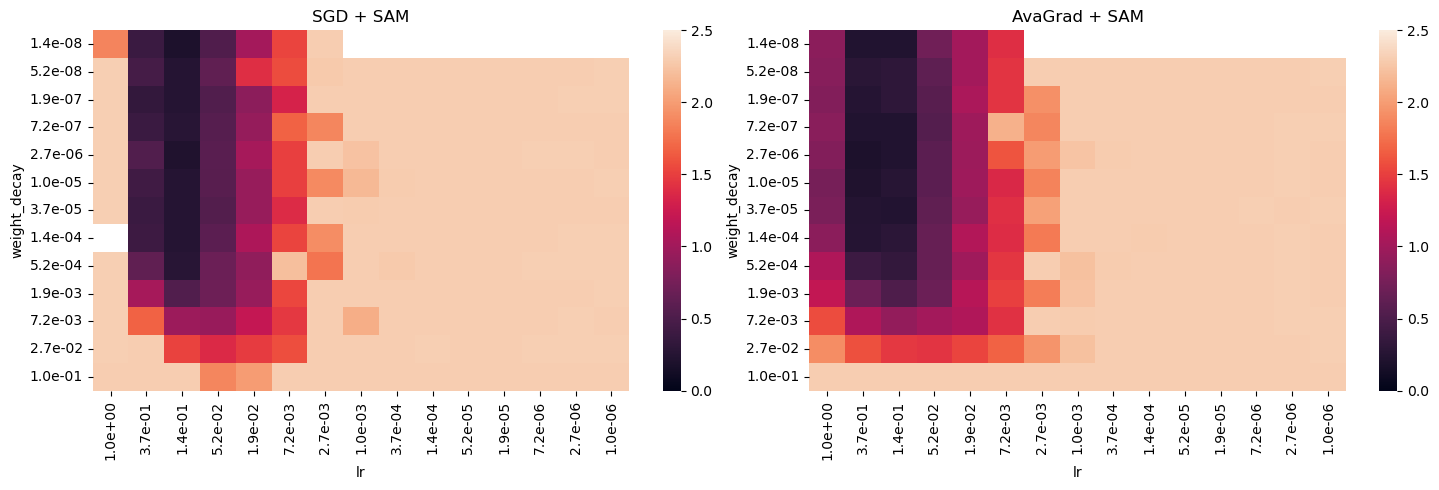

In [10]:
train_loss_sam_sgd = metrics_df_cleaned[(metrics_df_cleaned["SAM"]==True) & (metrics_df_cleaned["optimizer"]=="<class 'torch.optim.sgd.SGD'>")].pivot(index="weight_decay", columns="lr", values="train_loss")
train_loss_sam_sgd.sort_index(axis=1, inplace=True, ascending=False)
train_loss_sam_avagrad = metrics_df_cleaned[(metrics_df_cleaned["SAM"]==True) & (metrics_df_cleaned["optimizer"]=="<class 'pytorch_optimizer.optimizer.avagrad.AvaGrad'>")].pivot(index="weight_decay", columns="lr", values="train_loss")
train_loss_sam_avagrad.sort_index(axis=1, inplace=True, ascending=False)


fig, axs = plt.subplots(1, 2, figsize=(15, 5))

plot_heatmap_2d(axs[0], train_loss_sam_sgd, "SGD + SAM")
plot_heatmap_2d(axs[1], train_loss_sam_avagrad ,"AvaGrad + SAM")
plt.show()

### Test loss

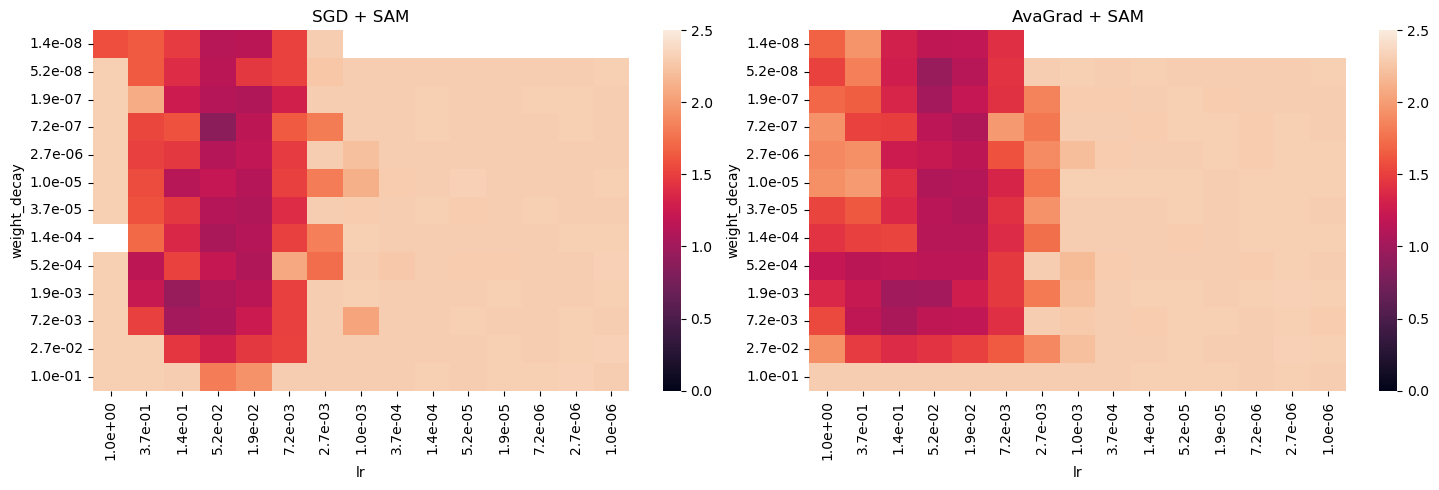

In [11]:
test_loss_sam_sgd = metrics_df_cleaned[(metrics_df_cleaned["SAM"]==True) & (metrics_df_cleaned["optimizer"]=="<class 'torch.optim.sgd.SGD'>")].pivot(index="weight_decay", columns="lr", values="val_loss")
test_loss_sam_sgd.sort_index(axis=1, inplace=True, ascending=False)
test_loss_sam_avagrad = metrics_df_cleaned[(metrics_df_cleaned["SAM"]==True) & (metrics_df_cleaned["optimizer"]=="<class 'pytorch_optimizer.optimizer.avagrad.AvaGrad'>")].pivot(index="weight_decay", columns="lr", values="val_loss")
test_loss_sam_avagrad.sort_index(axis=1, inplace=True, ascending=False)


fig, axs = plt.subplots(1, 2, figsize=(15, 5))

plot_heatmap_2d(axs[0], test_loss_sam_sgd, "SGD + SAM")
plot_heatmap_2d(axs[1], test_loss_sam_avagrad ,"AvaGrad + SAM")
plt.show()

### Diff Loss

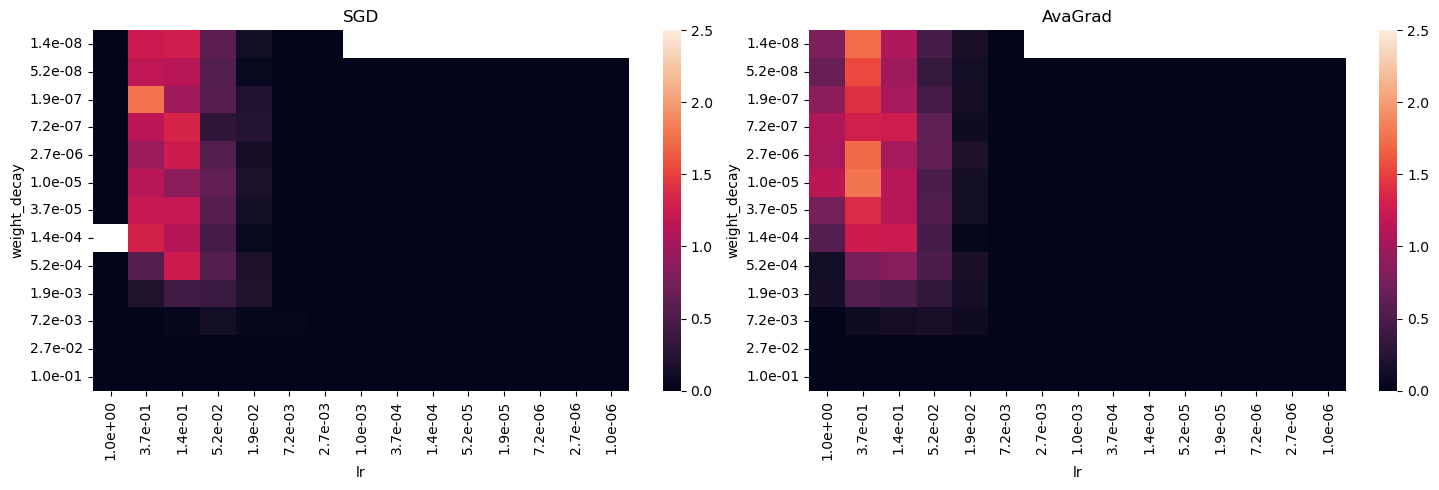

In [12]:
### Diff loss
diff_loss_sgd = metrics_df_cleaned[(metrics_df_cleaned["SAM"]==True) & (metrics_df_cleaned["optimizer"]=="<class 'torch.optim.sgd.SGD'>")].pivot(index="weight_decay", columns="lr", values="diff_loss")
diff_loss_sgd.sort_index(axis=1, inplace=True, ascending=False)
diff_loss_avagrad = metrics_df_cleaned[(metrics_df_cleaned["SAM"]==True) & (metrics_df_cleaned["optimizer"]=="<class 'pytorch_optimizer.optimizer.avagrad.AvaGrad'>")].pivot(index="weight_decay", columns="lr", values="diff_loss")
diff_loss_avagrad.sort_index(axis=1, inplace=True, ascending=False)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

plot_heatmap_2d(axs[0], diff_loss_sgd, "SGD")
plot_heatmap_2d(axs[1], diff_loss_avagrad, "AvaGrad")
plt.show()